In [1]:
%matplotlib notebook
import pandas as pd
import numpy as np
import os
import sklearn
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
import xgboost
from xgboost import XGBClassifier

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 500)
pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
data_path = '/home/mvkrein/etf_model/data'
etf_data_file = os.path.join(data_path,'etf_new_var_20180910.csv')
etf_data = pd.read_csv(etf_data_file,index_col=0)

In [4]:
etf_study_file = os.path.join(data_path,'ETF_list_min_6yr_history.csv')
etf_list = pd.read_csv(etf_study_file,index_col=0)
etf_data.sort_values(['Date','sym'],ascending=True,inplace=True)
etf_data.reset_index(drop=True,inplace=True)

In [5]:
drop_columns = ['Date','sym','p', 'v', 'p_L05', 'v_L05', 'p_L10', 'v_L10', 'p_L21', 'v_L21', 'p_L42', 'v_L42', 'p_L63', \
                'v_L63', 'p_L84', 'v_L84', 'p_L126', 'v_L126', 'p_L189', 'v_L189', 'p_L252', 'v_L252',\
                'p_L-21', 'v_L-21', 'delta_p_L05', 'delta_p_L10', 'delta_p_L21', 'delta_p_L42', 'delta_p_L63', \
                'delta_p_L84', 'delta_p_L126', 'delta_p_L189', 'delta_p_L252', 'delta_p_L-21', 'delta_v_L05',\
                'delta_v_L10', 'delta_v_L21', 'delta_v_L42', 'delta_v_L63', 'delta_v_L84', 'delta_v_L126', \
                'delta_v_L189', 'delta_v_L252','rank_p_L-21', 'ivv_delta_p_L-21', 'target']

rank_col = ['rank_p_L05','rank_p_L10','rank_p_L21','rank_p_L42',\
            'rank_p_L63','rank_p_L84','rank_p_L126','rank_p_L189','rank_p_L252']

In [6]:
all_columns = list(etf_data.columns)

In [7]:
include_columns = [x for x in all_columns if x not in drop_columns]
# include_columns = ['rank_p_L05','rank_p_L10','rank_p_L21','rank_p_L42',\
#             'rank_p_L63','rank_p_L84','rank_p_L126','rank_p_L189','rank_p_L252']
# include_columns = ['rank_p_L05','rank_p_L21','rank_p_L42','rank_p_L252']

In [8]:
len(include_columns)

360

In [9]:
dates = list(etf_data['Date'].unique())
# dates[1671]

In [10]:
symbols = etf_list['Symbol'].unique()

In [11]:
len(symbols)

153

In [14]:
#Each year has 252 trading dates.  Need two years to fully develop variables.
dt1 = 504 #This is the first day that all variables are developed
# dt1 = 504 + 21 + 273 #This is the first day that all variables are developed 2016-04-07
# make all dates relative to dt1
# for one year training - add 252
# to evaluate for one month outside the training window - add 273
# to predict for the first day outside of the evaluation window (have to lag 21) - add 294
dt_end = (len(dates) - 273 - 21) - 1
# dt_end = dt1 + 1
#etf_predict_file = os.path.join(data_path,'etf_pred_ridge_20180920.csv')
k = 0

In [15]:

for i in range(dt1,dt_end):
    print("Building model to predict for ",dates[i+273])
    x_train = etf_data.loc[((etf_data['Date']>=dates[i]) & (etf_data['Date']<dates[i+252])),include_columns] #train with 12 mos
    y_train = etf_data.loc[((etf_data['Date']>=dates[i]) & (etf_data['Date']<dates[i+252])),['rank_p_L-21']] #train with 12 mos

    x_test = etf_data.loc[(etf_data['Date']==dates[i+273]),include_columns]#predict one day-must be 21 days removed from training
    y_test = etf_data.loc[(etf_data['Date']==dates[i+273]),['rank_p_L-21']] #predict if etf >= market
    returns = etf_data.loc[(etf_data['Date']==dates[i+273]),['delta_p_L-21']]
    mkt_return = etf_data.loc[(etf_data['Date']==dates[i+273]),['ivv_delta_p_L-21']]
    x_train_nmpy = x_train.as_matrix()
    y_train_nmpy = np.ravel(y_train.as_matrix())

    x_test_nmpy = x_test.as_matrix()
    y_test_nmpy = np.ravel(y_test.as_matrix())
    returns_nmpy = returns.as_matrix()
    mkt_return_nmpy = mkt_return.as_matrix()

#     lm = linear_model.Ridge (alpha = 0.8)
    lm = LinearRegression()

    lm.fit(x_train_nmpy, y_train_nmpy)
    
    y_pred_model = lm.predict(x_test_nmpy)


    y_check = np.column_stack((y_test_nmpy, y_pred_model,mkt_return_nmpy,returns_nmpy))
    y_check_df = pd.DataFrame(y_check,columns=['true_value','pred_value','mkt_return','returns'])
    y_check_df.sort_values('pred_value',inplace=True,ascending=False)
    

    train_error = mean_squared_error(y_train_nmpy,lm.predict(x_train_nmpy))
    eval_error = mean_squared_error(y_test_nmpy,y_pred_model)

    print('Model Eval Results:')
    print('*****************************')

    print(f'training error: {train_error:.3}')
    print(f'evaluation error: {eval_error:.3}')
    print('R-squared score (training): {:.3f}'
     .format(lm.score(x_train_nmpy, y_train_nmpy)))
    print('R-squared score (test): {:.3f}'
     .format(lm.score(x_test_nmpy, y_test_nmpy)))

    print('*****************************')
    print("Model Top 5 Picks")
    print(" Avg rtn top 5:", round(y_check_df['returns'][0:5].mean(),4))
    print(y_check_df.head(5))
    print("Model Bottom 5 Picks")
    print(" Avg rtn bottom 5:", round(y_check_df['returns'][-5:].mean(),4))
    print(y_check_df.tail(5))
    print('********************************************************')
    etf_predict_file = os.path.join(data_path,('etf_pred_linear_regression_20180920_'+str(k%21)+'.csv'))
    if k < 21:
        predict_data = etf_data.loc[(etf_data['Date']==dates[i+273]),['Date','sym','rank_p_L-21']]
        predict_data['predict'] = y_pred_model
        predict_data.to_csv(etf_predict_file)
    else:
        predict_data = etf_data.loc[(etf_data['Date']==dates[i+273]),['Date','sym','rank_p_L-21']]
        predict_data['predict'] = y_pred_model
        predict_data.to_csv(etf_predict_file,header=False,mode='a')
    k+=1

Building model to predict for  2015-02-05
Model Eval Results:
*****************************
training error: 0.0703
evaluation error: 0.0632
R-squared score (training): 0.156
R-squared score (test): 0.242
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0389
     true_value  pred_value  mkt_return   returns
67     0.882353    0.778693    0.010741  0.031835
139    0.960784    0.768591    0.010741  0.060291
150    0.437908    0.693888    0.010741 -0.005800
45     0.888889    0.686970    0.010741  0.036401
70     0.986928    0.681261    0.010741  0.071770
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0414
     true_value  pred_value  mkt_return   returns
62     0.418301    0.306645    0.010741 -0.006829
15     0.764706    0.298483    0.010741  0.012313
138    0.032680    0.292481    0.010741 -0.089264
69     0.045752    0.274310    0.010741 -0.081433
78     0.137255    0.273047    0.010741 -0.041616
********************************************************
Building model to pr

Model Eval Results:
*****************************
training error: 0.0696
evaluation error: 0.082
R-squared score (training): 0.164
R-squared score (test): 0.016
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0151
     true_value  pred_value  mkt_return   returns
53     0.908497    0.659747    0.006621  0.036791
6      0.725490    0.629321    0.006621  0.018152
11     0.117647    0.619950    0.006621 -0.023331
139    0.888889    0.615186    0.006621  0.034051
52     0.555556    0.602920    0.006621  0.009874
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0246
     true_value  pred_value  mkt_return   returns
62     0.039216    0.266776    0.006621 -0.064269
23     0.222222    0.187734    0.006621 -0.007625
47     0.228758    0.173514    0.006621 -0.004339
104    0.535948    0.171161    0.006621  0.009434
31     0.045752    0.132770    0.006621 -0.056412
********************************************************
Building model to predict for  2015-02-20
Model Eval Results:
*

Model Eval Results:
*****************************
training error: 0.0682
evaluation error: 0.0885
R-squared score (training): 0.181
R-squared score (test): -0.062
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0433
     true_value  pred_value  mkt_return   returns
126    0.993464    0.677639    -0.01398  0.089161
6      0.901961    0.664312    -0.01398  0.033000
0      0.869281    0.641620    -0.01398  0.032085
11     0.954248    0.633242    -0.01398  0.045077
53     0.705882    0.616519    -0.01398  0.017006
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0319
     true_value  pred_value  mkt_return   returns
71     0.856209    0.236925    -0.01398  0.031104
146    0.934641    0.236361    -0.01398  0.036011
138    0.908497    0.204986    -0.01398  0.034216
133    0.915033    0.161057    -0.01398  0.034283
151    0.810458    0.141425    -0.01398  0.023849
********************************************************
Building model to predict for  2015-03-05
Model Eval Results:


Model Eval Results:
*****************************
training error: 0.0664
evaluation error: 0.0853
R-squared score (training): 0.203
R-squared score (test): -0.024
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0614
     true_value  pred_value  mkt_return   returns
56     0.418301    0.734435    0.016185  0.018623
79     0.607843    0.706222    0.016185  0.040103
152    0.797386    0.678259    0.016185  0.067885
51     0.692810    0.667240    0.016185  0.050801
39     0.947712    0.656587    0.016185  0.129524
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0176
     true_value  pred_value  mkt_return   returns
62     0.921569    0.266392    0.016185  0.112046
71     0.039216    0.265619    0.016185 -0.005748
139    0.026144    0.234591    0.016185 -0.010192
133    0.052288    0.195449    0.016185 -0.003889
151    0.045752    0.185148    0.016185 -0.003976
********************************************************
Building model to predict for  2015-03-18
Model Eval Results:


Model Eval Results:
*****************************
training error: 0.0651
evaluation error: 0.115
R-squared score (training): 0.218
R-squared score (test): -0.382
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0209
    true_value  pred_value  mkt_return   returns
70    0.084967    0.845528    0.011306 -0.018530
46    0.823529    0.784352    0.011306  0.061160
56    0.503268    0.775221    0.011306  0.012512
38    0.065359    0.749328    0.011306 -0.024045
57    0.888889    0.721717    0.011306  0.073211
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0484
     true_value  pred_value  mkt_return   returns
146    0.045752    0.158041    0.011306 -0.033869
54     0.993464    0.150114    0.011306  0.170795
143    0.366013    0.145934    0.011306  0.003404
145    0.156863    0.137357    0.011306 -0.010067
97     0.947712    0.042396    0.011306  0.111719
********************************************************
Building model to predict for  2015-03-31
Model Eval Results:
*******

Model Eval Results:
*****************************
training error: 0.0652
evaluation error: 0.098
R-squared score (training): 0.216
R-squared score (test): -0.199
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0162
    true_value  pred_value  mkt_return   returns
38    0.241830    0.950552    0.004229 -0.012901
46    0.960784    0.939113    0.004229  0.066543
70    0.196078    0.897469    0.004229 -0.018224
33    0.875817    0.886542    0.004229  0.029487
83    0.751634    0.862765    0.004229  0.015994
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0005
     true_value  pred_value  mkt_return   returns
55     0.797386    0.177736    0.004229  0.021441
143    0.019608    0.139175    0.004229 -0.073789
146    0.013072    0.125399    0.004229 -0.074838
54     0.980392    0.095198    0.004229  0.080793
97     0.921569    0.054099    0.004229  0.048931
********************************************************
Building model to predict for  2015-04-14
Model Eval Results:
*******

Model Eval Results:
*****************************
training error: 0.0651
evaluation error: 0.0891
R-squared score (training): 0.218
R-squared score (test): -0.070
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.006
     true_value  pred_value  mkt_return   returns
83     0.640523    0.933384   -0.004459 -0.005770
130    0.464052    0.898886   -0.004459 -0.009652
70     0.477124    0.896163   -0.004459 -0.009348
33     0.921569    0.877259   -0.004459  0.009737
38     0.359477    0.873622   -0.004459 -0.014770
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0553
     true_value  pred_value  mkt_return   returns
54     0.006536    0.106837   -0.004459 -0.111111
39     0.960784    0.103370   -0.004459  0.023830
146    0.071895    0.081731   -0.004459 -0.049265
55     0.013072    0.059558   -0.004459 -0.105512
18     0.150327    0.058191   -0.004459 -0.034292
********************************************************
Building model to predict for  2015-04-27
Model Eval Results:

Model Eval Results:
*****************************
training error: 0.065
evaluation error: 0.0537
R-squared score (training): 0.219
R-squared score (test): 0.356
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0059
     true_value  pred_value  mkt_return   returns
66     0.967320    0.928032   -0.001902  0.038891
72     0.052288    0.925261   -0.001902 -0.069268
130    0.888889    0.865622   -0.001902  0.018136
83     0.810458    0.819141   -0.001902  0.006066
88     0.960784    0.809355   -0.001902  0.035501
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0425
     true_value  pred_value  mkt_return   returns
80     0.235294    0.180104   -0.001902 -0.029327
102    0.392157    0.157241   -0.001902 -0.012224
143    0.352941    0.139923   -0.001902 -0.016112
57     0.032680    0.089732   -0.001902 -0.086982
148    0.058824   -0.019268   -0.001902 -0.067742
********************************************************
Building model to predict for  2015-05-08
Model Eval Results:
*

Model Eval Results:
*****************************
training error: 0.0643
evaluation error: 0.0609
R-squared score (training): 0.227
R-squared score (test): 0.269
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0015
     true_value  pred_value  mkt_return   returns
72     0.098039    0.790792   -0.006953 -0.059822
146    0.869281    0.774471   -0.006953  0.005449
88     0.928105    0.747307   -0.006953  0.014813
66     0.967320    0.733614   -0.006953  0.021754
130    0.888889    0.717001   -0.006953  0.010125
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0581
     true_value  pred_value  mkt_return   returns
80     0.189542    0.211159   -0.006953 -0.044017
143    0.307190    0.206154   -0.006953 -0.028597
14     0.013072    0.205059   -0.006953 -0.093502
99     0.333333    0.133806   -0.006953 -0.025842
148    0.006536    0.103384   -0.006953 -0.098434
********************************************************
Building model to predict for  2015-05-21
Model Eval Results:

Model Eval Results:
*****************************
training error: 0.0628
evaluation error: 0.0753
R-squared score (training): 0.246
R-squared score (test): 0.097
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0369
     true_value  pred_value  mkt_return   returns
15     0.006536    0.894605   -0.017036 -0.162766
25     0.934641    0.759779   -0.017036  0.004998
52     0.816993    0.686335   -0.017036 -0.000158
146    0.647059    0.681836   -0.017036 -0.010165
69     0.470588    0.668886   -0.017036 -0.016579
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0402
    true_value  pred_value  mkt_return   returns
38    0.156863    0.301706   -0.017036 -0.041076
41    0.503268    0.279546   -0.017036 -0.016275
37    0.058824    0.231678   -0.017036 -0.062000
62    0.575163    0.201697   -0.017036 -0.013314
46    0.039216    0.097188   -0.017036 -0.068197
********************************************************
Building model to predict for  2015-06-04
Model Eval Results:
*****

Model Eval Results:
*****************************
training error: 0.0615
evaluation error: 0.0996
R-squared score (training): 0.261
R-squared score (test): -0.196
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0263
     true_value  pred_value  mkt_return   returns
15     0.006536    0.875202    0.014324 -0.171331
57     0.973856    0.662595    0.014324  0.042704
64     0.738562    0.649562    0.014324  0.012547
55     0.209150    0.644481    0.014324 -0.019393
108    0.549020    0.626135    0.014324  0.003934
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0191
     true_value  pred_value  mkt_return   returns
138    0.065359    0.248444    0.014324 -0.063316
139    0.058824    0.245518    0.014324 -0.063940
41     0.509804    0.230484    0.014324  0.002038
134    0.568627    0.183727    0.014324  0.005091
38     0.875817    0.170777    0.014324  0.024489
********************************************************
Building model to predict for  2015-06-17
Model Eval Results

Model Eval Results:
*****************************
training error: 0.0606
evaluation error: 0.0875
R-squared score (training): 0.271
R-squared score (test): -0.050
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.013
    true_value  pred_value  mkt_return   returns
15    0.013072    0.833887    0.025744 -0.119943
47    0.901961    0.792759    0.025744  0.033731
84    0.797386    0.756393    0.025744  0.023133
37    0.281046    0.729297    0.025744 -0.014303
68    0.660131    0.716171    0.025744  0.012593
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0009
     true_value  pred_value  mkt_return   returns
138    0.117647    0.284153    0.025744 -0.058550
139    0.163399    0.270414    0.025744 -0.038579
70     0.954248    0.242598    0.025744  0.046759
134    0.549020    0.185701    0.025744  0.005815
88     0.960784    0.174304    0.025744  0.048888
********************************************************
Building model to predict for  2015-06-30
Model Eval Results:
******

Model Eval Results:
*****************************
training error: 0.0597
evaluation error: 0.0779
R-squared score (training): 0.282
R-squared score (test): 0.065
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0168
    true_value  pred_value  mkt_return   returns
15    0.156863    0.938781   -0.005543 -0.058540
45    0.823529    0.735794   -0.005543  0.010274
43    0.313725    0.734926   -0.005543 -0.018529
68    0.725490    0.732787   -0.005543  0.002438
37    0.307190    0.729302   -0.005543 -0.019680
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.056
     true_value  pred_value  mkt_return   returns
126    0.196078    0.075543   -0.005543 -0.042436
6      0.150327    0.054000   -0.005543 -0.060234
60     0.176471    0.038823   -0.005543 -0.047075
16     0.104575    0.009598   -0.005543 -0.067424
11     0.130719   -0.007492   -0.005543 -0.062708
********************************************************
Building model to predict for  2015-07-14
Model Eval Results:
******

Model Eval Results:
*****************************
training error: 0.0595
evaluation error: 0.0759
R-squared score (training): 0.284
R-squared score (test): 0.089
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0722
     true_value  pred_value  mkt_return   returns
139    0.222222    0.935311    -0.08951 -0.117079
104    0.869281    0.869845    -0.08951  0.000368
103    0.718954    0.850861    -0.08951 -0.049562
68     0.241830    0.824644    -0.08951 -0.114162
37     0.529412    0.822376    -0.08951 -0.080488
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.1642
    true_value  pred_value  mkt_return   returns
6     0.078431   -0.038924    -0.08951 -0.170978
60    0.065359   -0.085068    -0.08951 -0.180925
16    0.117647   -0.093225    -0.08951 -0.155154
18    0.156863   -0.102665    -0.08951 -0.142419
11    0.071895   -0.175416    -0.08951 -0.171330
********************************************************
Building model to predict for  2015-07-27
Model Eval Results:
*****

Model Eval Results:
*****************************
training error: 0.0588
evaluation error: 0.0773
R-squared score (training): 0.293
R-squared score (test): 0.072
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0535
     true_value  pred_value  mkt_return   returns
104    0.947712    1.023761   -0.076446  0.005111
68     0.261438    0.917747   -0.076446 -0.099677
103    0.712418    0.906537   -0.076446 -0.054852
139    0.725490    0.901373   -0.076446 -0.053717
121    0.660131    0.805777   -0.076446 -0.064390
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.1163
    true_value  pred_value  mkt_return   returns
18    0.228758    0.031192   -0.076446 -0.105676
54    0.045752   -0.033376   -0.076446 -0.151047
97    0.137255   -0.043010   -0.076446 -0.117469
32    0.673203   -0.067856   -0.076446 -0.063880
11    0.071895   -0.177306   -0.076446 -0.143239
********************************************************
Building model to predict for  2015-08-07
Model Eval Results:
*****

Model Eval Results:
*****************************
training error: 0.0577
evaluation error: 0.105
R-squared score (training): 0.306
R-squared score (test): -0.254
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0456
     true_value  pred_value  mkt_return   returns
112    0.751634    0.771540   -0.057165 -0.009739
104    0.307190    0.763537   -0.057165 -0.055481
68     0.039216    0.761846   -0.057165 -0.090412
25     0.084967    0.741325   -0.057165 -0.073790
127    0.862745    0.720129   -0.057165  0.001367
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0229
    true_value  pred_value  mkt_return   returns
97    0.372549    0.217146   -0.057165 -0.053989
11    0.156863    0.204808   -0.057165 -0.061801
46    0.143791    0.199923   -0.057165 -0.062230
44    0.986928    0.199733   -0.057165  0.038614
32    0.973856    0.131567   -0.057165  0.024855
********************************************************
Building model to predict for  2015-08-20
Model Eval Results:
*****

Model Eval Results:
*****************************
training error: 0.0577
evaluation error: 0.0803
R-squared score (training): 0.307
R-squared score (test): 0.036
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0369
     true_value  pred_value  mkt_return   returns
71     0.986928    0.901473    0.008239  0.064331
133    0.993464    0.881844    0.008239  0.066666
151    0.954248    0.848693    0.008239  0.037758
57     0.470588    0.815764    0.008239 -0.000922
146    0.843137    0.811078    0.008239  0.016693
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0161
     true_value  pred_value  mkt_return   returns
14     0.045752    0.260382    0.008239 -0.047205
66     0.320261    0.246296    0.008239 -0.011507
52     0.647059    0.228728    0.008239  0.004293
62     0.196078    0.219478    0.008239 -0.020208
102    0.398693    0.206903    0.008239 -0.006002
********************************************************
Building model to predict for  2015-09-02
Model Eval Results:


Model Eval Results:
*****************************
training error: 0.0579
evaluation error: 0.0734
R-squared score (training): 0.304
R-squared score (test): 0.119
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0795
     true_value  pred_value  mkt_return   returns
23     0.986928    0.819978    0.009205  0.097780
151    0.908497    0.814236    0.009205  0.059884
79     0.901961    0.808128    0.009205  0.059292
148    0.993464    0.789578    0.009205  0.118512
71     0.921569    0.758613    0.009205  0.062199
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0037
     true_value  pred_value  mkt_return   returns
29     0.183007    0.277793    0.009205 -0.002255
89     0.026144    0.245302    0.009205 -0.065963
60     0.862745    0.237648    0.009205  0.052126
126    0.843137    0.221384    0.009205  0.047587
66     0.045752    0.110181    0.009205 -0.049869
********************************************************
Building model to predict for  2015-09-16
Model Eval Results:


Model Eval Results:
*****************************
training error: 0.059
evaluation error: 0.0831
R-squared score (training): 0.292
R-squared score (test): 0.002
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.1305
     true_value  pred_value  mkt_return   returns
148    0.934641    0.819674    0.099307  0.134222
79     0.411765    0.793572    0.099307  0.067977
118    0.274510    0.762925    0.099307  0.050609
23     1.000000    0.755658    0.099307  0.302592
48     0.738562    0.727475    0.099307  0.096939
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0934
     true_value  pred_value  mkt_return   returns
53     0.986928    0.227127    0.099307  0.153454
66     0.392157    0.221700    0.099307  0.065435
126    0.967320    0.215903    0.099307  0.138400
62     0.006536    0.204034    0.099307 -0.022485
60     0.928105    0.197716    0.099307  0.132043
********************************************************
Building model to predict for  2015-09-29
Model Eval Results:
**

Model Eval Results:
*****************************
training error: 0.0596
evaluation error: 0.067
R-squared score (training): 0.283
R-squared score (test): 0.196
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0078
     true_value  pred_value  mkt_return   returns
79     0.254902    0.805973    0.033136 -0.029630
83     0.973856    0.748663    0.033136  0.062901
84     0.542484    0.720794    0.033136 -0.002115
46     0.562092    0.715768    0.033136 -0.001248
121    0.699346    0.706274    0.033136  0.009079
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.025
     true_value  pred_value  mkt_return   returns
6      0.437908    0.187419    0.033136 -0.007718
44     0.013072    0.167143    0.033136 -0.092940
53     0.477124    0.159339    0.033136 -0.005806
60     0.366013    0.137682    0.033136 -0.012675
126    0.470588    0.132216    0.033136 -0.005890
********************************************************
Building model to predict for  2015-10-12
Model Eval Results:
**

Model Eval Results:
*****************************
training error: 0.0602
evaluation error: 0.0651
R-squared score (training): 0.277
R-squared score (test): 0.219
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0351
     true_value  pred_value  mkt_return   returns
89     0.934641    0.792147    0.020743  0.037125
90     0.960784    0.737612    0.020743  0.060567
131    0.607843    0.736382    0.020743  0.003092
143    0.169935    0.690250    0.020743 -0.030975
88     1.000000    0.686541    0.020743  0.105887
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0212
     true_value  pred_value  mkt_return   returns
6      0.248366    0.245887    0.020743 -0.024317
15     0.581699    0.237247    0.020743  0.000650
60     0.163399    0.218111    0.020743 -0.030982
126    0.294118    0.196774    0.020743 -0.020200
44     0.156863    0.156424    0.020743 -0.031336
********************************************************
Building model to predict for  2015-10-23
Model Eval Results:


Model Eval Results:
*****************************
training error: 0.0603
evaluation error: 0.0929
R-squared score (training): 0.276
R-squared score (test): -0.115
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0303
     true_value  pred_value  mkt_return   returns
143    0.091503    0.839327   -0.003687 -0.057326
50     0.084967    0.819646   -0.003687 -0.057692
132    0.235294    0.698392   -0.003687 -0.020979
26     0.398693    0.693995   -0.003687 -0.008807
89     0.444444    0.693992   -0.003687 -0.006480
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0379
     true_value  pred_value  mkt_return   returns
78     0.065359    0.247046   -0.003687 -0.073245
51     0.169935    0.242229   -0.003687 -0.036261
60     0.137255    0.173244   -0.003687 -0.044990
126    0.189542    0.159267   -0.003687 -0.033092
15     0.653595    0.118833   -0.003687 -0.001742
********************************************************
Building model to predict for  2015-11-05
Model Eval Results

Model Eval Results:
*****************************
training error: 0.0607
evaluation error: 0.12
R-squared score (training): 0.271
R-squared score (test): -0.444
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0592
     true_value  pred_value  mkt_return   returns
50     0.202614    0.854236   -0.002275 -0.026451
57     0.013072    0.834752   -0.002275 -0.121853
143    0.065359    0.806506   -0.002275 -0.072484
18     0.143791    0.790313   -0.002275 -0.036364
16     0.130719    0.785348   -0.002275 -0.039014
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0687
     true_value  pred_value  mkt_return   returns
146    0.954248    0.251272   -0.002275  0.025381
55     0.026144    0.242486   -0.002275 -0.109317
78     0.045752    0.238394   -0.002275 -0.103379
101    0.058824    0.196225   -0.002275 -0.086223
29     0.071895    0.192743   -0.002275 -0.069984
********************************************************
Building model to predict for  2015-11-18
Model Eval Results:


Model Eval Results:
*****************************
training error: 0.0603
evaluation error: 0.148
R-squared score (training): 0.275
R-squared score (test): -0.771
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0484
    true_value  pred_value  mkt_return   returns
11    0.307190    0.994561   -0.026878 -0.037540
57    0.039216    0.986656   -0.026878 -0.101772
16    0.209150    0.846107   -0.026878 -0.045504
49    0.555556    0.821726   -0.026878 -0.022892
41    0.346405    0.799447   -0.026878 -0.034043
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0156
     true_value  pred_value  mkt_return   returns
74     0.803922    0.171757   -0.026878 -0.005445
146    0.647059    0.163264   -0.026878 -0.016260
138    0.542484    0.161620   -0.026878 -0.023686
98     0.522876    0.149174   -0.026878 -0.024759
69     0.758170    0.127323   -0.026878 -0.007759
********************************************************
Building model to predict for  2015-12-02
Model Eval Results:
*****

Model Eval Results:
*****************************
training error: 0.0606
evaluation error: 0.169
R-squared score (training): 0.272
R-squared score (test): -1.031
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0871
    true_value  pred_value  mkt_return   returns
11    0.143791    1.018725    -0.04945 -0.080612
57    0.052288    1.003450    -0.04945 -0.095304
15    0.418301    0.898770    -0.04945 -0.049373
72    0.163399    0.889579    -0.04945 -0.076056
55    0.032680    0.872603    -0.04945 -0.134319
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0147
     true_value  pred_value  mkt_return   returns
137    0.843137    0.158722    -0.04945  0.002641
136    0.816993    0.154919    -0.04945  0.000735
74     0.934641    0.154913    -0.04945  0.009176
59     0.810458    0.153740    -0.04945  0.000139
112    0.117647    0.111755    -0.04945 -0.086190
********************************************************
Building model to predict for  2015-12-15
Model Eval Results:
*****

Model Eval Results:
*****************************
training error: 0.0609
evaluation error: 0.103
R-squared score (training): 0.268
R-squared score (test): -0.241
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.1257
    true_value  pred_value  mkt_return   returns
79    0.594771    0.831197   -0.077806 -0.073777
15    0.013072    0.813731   -0.077806 -0.168895
57    0.163399    0.794624   -0.077806 -0.112916
11    0.104575    0.762484   -0.077806 -0.131712
55    0.078431    0.755205   -0.077806 -0.141243
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0976
     true_value  pred_value  mkt_return   returns
114    0.124183    0.290940   -0.077806 -0.125296
78     0.137255    0.286469   -0.077806 -0.120301
27     0.660131    0.285901   -0.077806 -0.058394
148    0.725490    0.274252   -0.077806 -0.044591
112    0.091503    0.220071   -0.077806 -0.139602
********************************************************
Building model to predict for  2015-12-29
Model Eval Results:
*****

Model Eval Results:
*****************************
training error: 0.0613
evaluation error: 0.108
R-squared score (training): 0.263
R-squared score (test): -0.301
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0863
     true_value  pred_value  mkt_return   returns
84     0.039216    0.796864   -0.035642 -0.111013
117    0.045752    0.770085   -0.035642 -0.102875
83     0.124183    0.722745   -0.035642 -0.077438
15     0.071895    0.693607   -0.035642 -0.094742
67     0.352941    0.688981   -0.035642 -0.045321
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0286
     true_value  pred_value  mkt_return   returns
44     0.967320    0.280594   -0.035642  0.078404
89     0.189542    0.276758   -0.035642 -0.067775
146    0.973856    0.260047   -0.035642  0.090418
27     0.758170    0.226014   -0.035642  0.006014
148    0.895425    0.193569   -0.035642  0.036106
********************************************************
Building model to predict for  2016-01-12
Model Eval Results:


Model Eval Results:
*****************************
training error: 0.0612
evaluation error: 0.107
R-squared score (training): 0.265
R-squared score (test): -0.288
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0269
     true_value  pred_value  mkt_return   returns
117    0.183007    0.829454    0.029962 -0.000527
112    0.261438    0.826984    0.029962  0.003990
68     0.405229    0.812820    0.029962  0.014330
95     0.849673    0.811395    0.029962  0.063991
84     0.797386    0.782769    0.029962  0.052809
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0698
     true_value  pred_value  mkt_return   returns
45     0.169935    0.150960    0.029962 -0.001331
69     0.954248    0.145807    0.029962  0.107376
138    0.875817    0.134291    0.029962  0.069219
148    0.960784    0.128566    0.029962  0.107499
23     0.862745    0.104300    0.029962  0.066180
********************************************************
Building model to predict for  2016-01-26
Model Eval Results:
*

Model Eval Results:
*****************************
training error: 0.0605
evaluation error: 0.108
R-squared score (training): 0.273
R-squared score (test): -0.294
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0703
     true_value  pred_value  mkt_return   returns
83     0.803922    0.776992    0.055758  0.077209
150    0.509804    0.757316    0.055758  0.049184
87     0.921569    0.743733    0.055758  0.096087
118    0.823529    0.738616    0.055758  0.079004
64     0.522876    0.731170    0.055758  0.050241
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0365
     true_value  pred_value  mkt_return   returns
38     0.281046    0.207519    0.055758  0.027119
148    0.627451    0.187071    0.055758  0.058258
25     0.176471    0.129929    0.055758  0.014553
29     0.529412    0.118980    0.055758  0.050488
23     0.346405    0.021787    0.055758  0.032186
********************************************************
Building model to predict for  2016-02-08
Model Eval Results:
*

Model Eval Results:
*****************************
training error: 0.0616
evaluation error: 0.112
R-squared score (training): 0.260
R-squared score (test): -0.338
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0637
     true_value  pred_value  mkt_return   returns
64     0.294118    0.830047    0.072254  0.054699
99     0.830065    0.817501    0.072254  0.112411
150    0.287582    0.801431    0.072254  0.054616
146    0.013072    0.772317    0.072254 -0.020586
139    0.862745    0.761932    0.072254  0.117489
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0526
     true_value  pred_value  mkt_return   returns
76     0.392157    0.285733    0.072254  0.069090
70     0.019608    0.283019    0.072254 -0.020395
29     0.673203    0.279304    0.072254  0.092582
135    0.542484    0.274467    0.072254  0.078077
25     0.235294    0.269554    0.072254  0.043459
********************************************************
Building model to predict for  2016-02-22
Model Eval Results:
*

Model Eval Results:
*****************************
training error: 0.063
evaluation error: 0.1
R-squared score (training): 0.244
R-squared score (test): -0.200
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0269
     true_value  pred_value  mkt_return   returns
117    0.124183    0.888516    0.038038  0.007010
67     0.555556    0.844484    0.038038  0.035268
66     0.254902    0.843044    0.038038  0.016147
129    0.568627    0.831869    0.038038  0.036792
113    0.666667    0.810467    0.038038  0.039186
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0068
     true_value  pred_value  mkt_return   returns
40     0.039216    0.170146    0.038038 -0.011647
69     0.013072    0.157204    0.038038 -0.036976
138    0.032680    0.145346    0.038038 -0.020690
102    0.490196    0.054002    0.038038  0.031038
23     0.111111    0.039107    0.038038  0.004246
********************************************************
Building model to predict for  2016-03-04
Model Eval Results:
***

Model Eval Results:
*****************************
training error: 0.0629
evaluation error: 0.0797
R-squared score (training): 0.244
R-squared score (test): 0.044
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0481
     true_value  pred_value  mkt_return   returns
66     0.287582    1.144386     0.02643  0.018643
117    0.803922    1.131796     0.02643  0.041973
70     0.980392    1.038977     0.02643  0.122195
68     0.705882    0.921151     0.02643  0.035321
67     0.346405    0.885899     0.02643  0.022244
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.002
     true_value  pred_value  mkt_return   returns
152    0.614379    0.163691     0.02643  0.031487
23     0.006536    0.150887     0.02643 -0.032057
40     0.013072    0.129569     0.02643 -0.028731
138    0.777778    0.110764     0.02643  0.039677
69     0.019608    0.010144     0.02643 -0.020559
********************************************************
Building model to predict for  2016-03-17
Model Eval Results:
*

Model Eval Results:
*****************************
training error: 0.0617
evaluation error: 0.087
R-squared score (training): 0.259
R-squared score (test): -0.044
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0637
     true_value  pred_value  mkt_return   returns
70     0.947712    1.150615       0.007  0.079744
117    0.901961    0.992475       0.007  0.057536
54     0.954248    0.974002       0.007  0.090469
55     0.941176    0.972806       0.007  0.074505
66     0.614379    0.953053       0.007  0.016043
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0303
     true_value  pred_value  mkt_return   returns
50     0.013072    0.255540       0.007 -0.055079
69     0.843137    0.210154       0.007  0.033812
53     0.111111    0.200971       0.007 -0.008257
40     0.745098    0.194863       0.007  0.023444
138    0.993464    0.179891       0.007  0.157350
********************************************************
Building model to predict for  2016-03-31
Model Eval Results:
*

Model Eval Results:
*****************************
training error: 0.0623
evaluation error: 0.0915
R-squared score (training): 0.252
R-squared score (test): -0.098
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0026
     true_value  pred_value  mkt_return   returns
70     0.026144    1.226202    0.002657 -0.071799
88     0.104575    1.122020    0.002657 -0.037351
89     0.908497    0.836912    0.002657  0.023434
117    0.960784    0.828300    0.002657  0.041052
66     0.934641    0.807382    0.002657  0.031733
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0252
    true_value  pred_value  mkt_return   returns
28    0.267974    0.172004    0.002657 -0.004319
0     0.071895    0.166669    0.002657 -0.043518
53    0.124183    0.150940    0.002657 -0.032406
6     0.091503    0.113350    0.002657 -0.039740
32    0.248366    0.013678    0.002657 -0.005857
********************************************************
Building model to predict for  2016-04-13
Model Eval Results:
****

Model Eval Results:
*****************************
training error: 0.0625
evaluation error: 0.0679
R-squared score (training): 0.249
R-squared score (test): 0.186
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0105
     true_value  pred_value  mkt_return   returns
70     0.130719    1.159179   -0.003434 -0.048645
88     0.352941    1.075039   -0.003434 -0.014792
89     0.254902    0.818339   -0.003434 -0.027732
103    0.980392    0.729622   -0.003434  0.034102
127    0.836601    0.716598   -0.003434  0.004741
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0507
     true_value  pred_value  mkt_return   returns
126    0.091503    0.198637   -0.003434 -0.051945
17     0.169935    0.187341   -0.003434 -0.039366
6      0.124183    0.171673   -0.003434 -0.048853
53     0.032680    0.149282   -0.003434 -0.069437
32     0.156863   -0.097335   -0.003434 -0.043956
********************************************************
Building model to predict for  2016-04-26
Model Eval Results:

Model Eval Results:
*****************************
training error: 0.0628
evaluation error: 0.134
R-squared score (training): 0.245
R-squared score (test): -0.610
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0576
     true_value  pred_value  mkt_return   returns
70     0.960784    1.029595    0.028819  0.091978
88     0.986928    0.941882    0.028819  0.114706
99     0.928105    0.789297    0.028819  0.075592
127    0.150327    0.776195    0.028819  0.002900
128    0.143791    0.762717    0.028819  0.002679
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0492
     true_value  pred_value  mkt_return   returns
60     0.934641    0.232923    0.028819  0.078792
27     0.581699    0.230349    0.028819  0.036133
11     0.679739    0.229304    0.028819  0.039563
126    0.856209    0.205385    0.028819  0.057825
32     0.535948   -0.134996    0.028819  0.033784
********************************************************
Building model to predict for  2016-05-09
Model Eval Results:
*

Model Eval Results:
*****************************
training error: 0.063
evaluation error: 0.144
R-squared score (training): 0.244
R-squared score (test): -0.726
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0329
     true_value  pred_value  mkt_return   returns
146    0.673203    0.976438    0.023138  0.033724
145    0.424837    0.927937    0.023138  0.022695
99     0.954248    0.891928    0.023138  0.069661
73     0.274510    0.857010    0.023138  0.016845
133    0.411765    0.838735    0.023138  0.021592
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0471
    true_value  pred_value  mkt_return   returns
78    0.986928    0.186180    0.023138  0.092899
36    0.712418    0.173461    0.023138  0.037469
81    0.764706    0.143937    0.023138  0.043657
75    0.653595    0.089474    0.023138  0.030991
32    0.640523   -0.232126    0.023138  0.030605
********************************************************
Building model to predict for  2016-05-20
Model Eval Results:
********

Model Eval Results:
*****************************
training error: 0.0629
evaluation error: 0.0845
R-squared score (training): 0.245
R-squared score (test): -0.014
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0622
     true_value  pred_value  mkt_return   returns
146    0.947712    1.166385    0.000367  0.072081
145    0.830065    0.965301    0.000367  0.043128
69     0.980392    0.893614    0.000367  0.112350
73     0.738562    0.881192    0.000367  0.030749
133    0.888889    0.825481    0.000367  0.052486
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0082
     true_value  pred_value  mkt_return   returns
11     0.843137    0.117993    0.000367  0.045448
126    0.686275    0.113813    0.000367  0.020691
75     0.509804    0.107207    0.000367  0.006357
68     0.045752    0.097047    0.000367 -0.083691
32     0.882353   -0.204457    0.000367  0.052438
********************************************************
Building model to predict for  2016-06-03
Model Eval Results:


Model Eval Results:
*****************************
training error: 0.0645
evaluation error: 0.0751
R-squared score (training): 0.226
R-squared score (test): 0.098
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0547
     true_value  pred_value  mkt_return   returns
146    0.254902    0.795384    0.044527  0.020947
70     0.464052    0.768151    0.044527  0.038900
148    0.882353    0.726467    0.044527  0.076453
23     0.954248    0.706130    0.044527  0.095163
139    0.542484    0.697014    0.044527  0.042161
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0321
     true_value  pred_value  mkt_return   returns
102    0.039216    0.252111    0.044527 -0.015236
132    0.352941    0.206091    0.044527  0.030227
68     0.300654    0.205261    0.044527  0.024553
32     0.934641    0.192469    0.044527  0.084729
65     0.437908    0.187824    0.044527  0.036168
********************************************************
Building model to predict for  2016-06-16
Model Eval Results:
*

Model Eval Results:
*****************************
training error: 0.0654
evaluation error: 0.0588
R-squared score (training): 0.216
R-squared score (test): 0.295
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.1311
     true_value  pred_value  mkt_return   returns
70     0.973856    0.777674    0.066836  0.147690
88     0.947712    0.719238    0.066836  0.117423
54     0.954248    0.711913    0.066836  0.129338
139    0.986928    0.708156    0.066836  0.157580
83     0.921569    0.707822    0.066836  0.103565
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0428
     true_value  pred_value  mkt_return   returns
140    0.084967    0.301481    0.066836 -0.000986
132    0.366013    0.292234    0.066836  0.049603
102    0.065359    0.249415    0.066836 -0.002323
138    0.967320    0.233905    0.066836  0.136014
65     0.267974    0.226679    0.066836  0.031917
********************************************************
Building model to predict for  2016-06-29
Model Eval Results:
*

Model Eval Results:
*****************************
training error: 0.0654
evaluation error: 0.0876
R-squared score (training): 0.214
R-squared score (test): -0.052
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0772
     true_value  pred_value  mkt_return   returns
54     0.986928    0.899382    0.012489  0.102067
55     1.000000    0.860857    0.012489  0.146110
32     0.078431    0.859795    0.012489 -0.005029
97     0.934641    0.792366    0.012489  0.064612
139    0.954248    0.719738    0.012489  0.078220
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0275
     true_value  pred_value  mkt_return   returns
50     0.960784    0.309112    0.012489  0.079890
65     0.320261    0.296624    0.012489  0.006261
112    0.366013    0.295548    0.012489  0.009870
117    0.784314    0.282694    0.012489  0.037874
138    0.267974    0.184657    0.012489  0.003667
********************************************************
Building model to predict for  2016-07-13
Model Eval Results:


Model Eval Results:
*****************************
training error: 0.0644
evaluation error: 0.0684
R-squared score (training): 0.227
R-squared score (test): 0.179
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0414
    true_value  pred_value  mkt_return   returns
54    0.640523    0.978882    0.010555  0.032079
55    0.620915    0.918922    0.010555  0.030783
81    0.908497    0.858791    0.010555  0.054740
36    0.830065    0.831836    0.010555  0.046390
32    0.797386    0.793588    0.010555  0.043160
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0119
     true_value  pred_value  mkt_return   returns
59     0.150327    0.297609    0.010555  0.003540
117    0.738562    0.295166    0.010555  0.037203
65     0.392157    0.292041    0.010555  0.015985
137    0.091503    0.283365    0.010555  0.000599
141    0.130719    0.268277    0.010555  0.002235
********************************************************
Building model to predict for  2016-07-26
Model Eval Results:
*******

Model Eval Results:
*****************************
training error: 0.0637
evaluation error: 0.0905
R-squared score (training): 0.235
R-squared score (test): -0.086
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0398
    true_value  pred_value  mkt_return   returns
76    0.895425    0.829287    0.004421  0.051487
79    0.686275    0.805461    0.004421  0.025326
89    0.019608    0.782435    0.004421 -0.033391
46    0.980392    0.777825    0.004421  0.084112
24    0.967320    0.776134    0.004421  0.071390
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0217
    true_value  pred_value  mkt_return   returns
75    0.901961    0.294965    0.004421  0.051905
23    0.032680    0.289647    0.004421 -0.014706
52    0.745098    0.279743    0.004421  0.032764
18    0.653595    0.263958    0.004421  0.021873
50    0.562092    0.232661    0.004421  0.016861
********************************************************
Building model to predict for  2016-08-08
Model Eval Results:
************

Model Eval Results:
*****************************
training error: 0.063
evaluation error: 0.0965
R-squared score (training): 0.244
R-squared score (test): -0.158
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0312
    true_value  pred_value  mkt_return   returns
89    0.437908    0.938860   -0.020122 -0.019555
55    0.183007    0.799153   -0.020122 -0.033051
81    0.065359    0.770074   -0.020122 -0.055159
88    0.627451    0.765343   -0.020122 -0.013892
71    0.163399    0.763388   -0.020122 -0.034403
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0385
     true_value  pred_value  mkt_return   returns
56     0.352941    0.271361   -0.020122 -0.023916
84     0.986928    0.264614   -0.020122  0.029616
118    0.620915    0.245846   -0.020122 -0.014246
52     0.006536    0.229777   -0.020122 -0.124274
44     0.052288    0.131191   -0.020122 -0.059859
********************************************************
Building model to predict for  2016-08-19
Model Eval Results:
*****

Model Eval Results:
*****************************
training error: 0.062
evaluation error: 0.0971
R-squared score (training): 0.256
R-squared score (test): -0.166
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0402
    true_value  pred_value  mkt_return   returns
81    0.901961    0.901354    0.000067  0.037833
75    0.980392    0.885059    0.000067  0.052104
89    0.633987    0.843218    0.000067  0.009443
62    0.928105    0.779794    0.000067  0.040730
78    0.993464    0.732189    0.000067  0.061035
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0134
     true_value  pred_value  mkt_return   returns
129    0.294118    0.314612    0.000067 -0.000495
104    0.006536    0.285643    0.000067 -0.050449
84     0.973856    0.204854    0.000067  0.050017
139    0.941176    0.187589    0.000067  0.041913
83     0.816993    0.183188    0.000067  0.026210
********************************************************
Building model to predict for  2016-09-01
Model Eval Results:
*******

Model Eval Results:
*****************************
training error: 0.0607
evaluation error: 0.108
R-squared score (training): 0.272
R-squared score (test): -0.295
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0052
     true_value  pred_value  mkt_return   returns
81     0.921569    0.860465    0.004702  0.037103
44     0.392157    0.851018    0.004702  0.000000
146    0.287582    0.847487    0.004702 -0.004096
98     0.647059    0.788455    0.004702  0.005303
131    0.202614    0.773551    0.004702 -0.012547
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0028
     true_value  pred_value  mkt_return   returns
60     0.379085    0.277964    0.004702 -0.000805
84     0.725490    0.277504    0.004702  0.007173
139    0.882353    0.268439    0.004702  0.024759
101    0.222222    0.243495    0.004702 -0.010084
39     0.261438    0.176137    0.004702 -0.006931
********************************************************
Building model to predict for  2016-09-15
Model Eval Results:
*

Model Eval Results:
*****************************
training error: 0.0601
evaluation error: 0.111
R-squared score (training): 0.279
R-squared score (test): -0.331
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0096
     true_value  pred_value  mkt_return   returns
44     0.751634    0.894944   -0.008258 -0.002466
88     0.019608    0.842247   -0.008258 -0.082357
81     0.921569    0.839420   -0.008258  0.032090
131    0.666667    0.768461   -0.008258 -0.004838
78     0.986928    0.754912   -0.008258  0.105614
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.039
     true_value  pred_value  mkt_return   returns
139    0.901961    0.238247   -0.008258  0.020883
11     0.830065    0.231790   -0.008258  0.003784
53     0.098039    0.167489   -0.008258 -0.046655
97     0.980392    0.079244   -0.008258  0.101526
54     1.000000    0.044138   -0.008258  0.115237
********************************************************
Building model to predict for  2016-09-28
Model Eval Results:
**

Model Eval Results:
*****************************
training error: 0.0604
evaluation error: 0.117
R-squared score (training): 0.275
R-squared score (test): -0.406
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0422
    true_value  pred_value  mkt_return   returns
57    0.947712    0.858485    -0.00934  0.035974
88    0.006536    0.848143    -0.00934 -0.105682
70    0.013072    0.847853    -0.00934 -0.091818
25    0.143791    0.826704    -0.00934 -0.037237
44    0.470588    0.822149    -0.00934 -0.012285
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0113
    true_value  pred_value  mkt_return   returns
32    0.130719    0.222092    -0.00934 -0.039693
53    0.183007    0.124818    -0.00934 -0.031443
55    0.921569    0.061321    -0.00934  0.021969
97    0.993464    0.003126    -0.00934  0.059219
54    0.986928   -0.090407    -0.00934  0.046557
********************************************************
Building model to predict for  2016-10-11
Model Eval Results:
************

Model Eval Results:
*****************************
training error: 0.0613
evaluation error: 0.0616
R-squared score (training): 0.264
R-squared score (test): 0.261
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0205
    true_value  pred_value  mkt_return   returns
88    0.699346    0.949075    0.028955  0.012414
70    0.901961    0.889129    0.028955  0.070732
44    0.084967    0.888162    0.028955 -0.073602
25    0.633987    0.875801    0.028955 -0.001494
84    0.954248    0.858813    0.028955  0.094534
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0586
    true_value  pred_value  mkt_return   returns
33    0.777778    0.186337    0.028955  0.026781
55    0.013072    0.150430    0.028955 -0.138438
32    0.771242    0.118471    0.028955  0.025685
97    0.052288    0.040028    0.028955 -0.100354
54    0.045752    0.012112    0.028955 -0.106434
********************************************************
Building model to predict for  2016-10-24
Model Eval Results:
************

Model Eval Results:
*****************************
training error: 0.0621
evaluation error: 0.0722
R-squared score (training): 0.254
R-squared score (test): 0.133
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0223
    true_value  pred_value  mkt_return   returns
72    0.156863    0.915389    0.057947 -0.044100
25    0.692810    0.909219    0.057947  0.042553
88    0.816993    0.865768    0.057947  0.073719
44    0.071895    0.861760    0.057947 -0.062183
70    0.875817    0.840329    0.057947  0.101511
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0709
    true_value  pred_value  mkt_return   returns
55    0.013072    0.262923    0.057947 -0.122093
73    0.150327    0.256169    0.057947 -0.044304
69    0.026144    0.226756    0.057947 -0.102789
31    0.549020    0.198508    0.057947  0.010188
54    0.032680    0.197992    0.057947 -0.095466
********************************************************
Building model to predict for  2016-11-04
Model Eval Results:
************

Model Eval Results:
*****************************
training error: 0.0632
evaluation error: 0.0896
R-squared score (training): 0.241
R-squared score (test): -0.094
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0153
     true_value  pred_value  mkt_return   returns
25     0.241830    0.869778    0.038725 -0.006905
72     0.326797    0.821846    0.038725  0.000000
44     0.156863    0.805901    0.038725 -0.015405
76     0.562092    0.744800    0.038725  0.026234
117    0.947712    0.738306    0.038725  0.072660
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.028
    true_value  pred_value  mkt_return   returns
54    0.026144    0.235677    0.038725 -0.046568
81    0.928105    0.233788    0.038725  0.063991
55    0.091503    0.231875    0.038725 -0.025854
31    0.248366    0.223205    0.038725 -0.005515
32    0.993464    0.185163    0.038725  0.153820
********************************************************
Building model to predict for  2016-11-17
Model Eval Results:
*******

Model Eval Results:
*****************************
training error: 0.0628
evaluation error: 0.0908
R-squared score (training): 0.246
R-squared score (test): -0.090
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0195
     true_value  pred_value  mkt_return   returns
117    0.875817    0.890600    0.021434  0.040643
25     0.294118    0.881043    0.021434  0.002276
70     0.039216    0.831684    0.021434 -0.031375
76     0.921569    0.815117    0.021434  0.049316
24     0.849673    0.772175    0.021434  0.036682
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0136
     true_value  pred_value  mkt_return   returns
103    0.104575    0.216693    0.021434 -0.015900
92     0.633987    0.205446    0.021434  0.018917
54     0.392157    0.194739    0.021434  0.008164
81     0.352941    0.187040    0.021434  0.006569
62     0.928105    0.153956    0.021434  0.050268
********************************************************
Building model to predict for  2016-12-01
Model Eval Results:


Model Eval Results:
*****************************
training error: 0.0632
evaluation error: 0.078
R-squared score (training): 0.241
R-squared score (test): 0.065
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0319
    true_value  pred_value  mkt_return   returns
70    0.960784    0.904739    0.002828  0.041094
29    0.986928    0.851820    0.002828  0.060317
79    0.359477    0.791312    0.002828  0.005791
25    0.673203    0.748157    0.002828  0.016459
88    0.934641    0.700649    0.002828  0.035675
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0002
     true_value  pred_value  mkt_return   returns
148    0.248366    0.190033    0.002828  0.002807
31     0.901961    0.171364    0.002828  0.032808
32     0.137255    0.130718    0.002828 -0.002030
23     0.078431    0.098408    0.002828 -0.007007
14     0.026144    0.060671    0.002828 -0.025514
********************************************************
Building model to predict for  2016-12-14
Model Eval Results:
********

Model Eval Results:
*****************************
training error: 0.0636
evaluation error: 0.0895
R-squared score (training): 0.237
R-squared score (test): -0.074
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0684
    true_value  pred_value  mkt_return   returns
11    0.960784    0.798958    0.012124  0.097708
79    0.065359    0.797531    0.012124 -0.007304
29    0.980392    0.795995    0.012124  0.127019
52    0.660131    0.747112    0.012124  0.038214
6     0.928105    0.726745    0.012124  0.086139
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.1178
    true_value  pred_value  mkt_return   returns
14    0.934641    0.234393    0.012124  0.087100
23    0.751634    0.213739    0.012124  0.049850
55    1.000000    0.183029    0.012124  0.209945
54    0.993464    0.165055    0.012124  0.161082
31    0.895425    0.165051    0.012124  0.081039
********************************************************
Building model to predict for  2016-12-28
Model Eval Results:
************

Model Eval Results:
*****************************
training error: 0.0641
evaluation error: 0.102
R-squared score (training): 0.231
R-squared score (test): -0.222
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0774
     true_value  pred_value  mkt_return   returns
52     0.986928    0.929189    0.018437  0.093899
29     0.980392    0.767462    0.018437  0.089811
47     0.300654    0.759930    0.018437  0.009239
148    1.000000    0.758167    0.018437  0.182333
67     0.326797    0.754645    0.018437  0.011599
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0639
     true_value  pred_value  mkt_return   returns
23     0.470588    0.230655    0.018437  0.016660
138    0.921569    0.203466    0.018437  0.052797
55     0.993464    0.134149    0.018437  0.141047
54     0.947712    0.130056    0.018437  0.062128
31     0.882353    0.098017    0.018437  0.047090
********************************************************
Building model to predict for  2017-01-11
Model Eval Results:
*

Model Eval Results:
*****************************
training error: 0.0645
evaluation error: 0.108
R-squared score (training): 0.225
R-squared score (test): -0.291
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0109
    true_value  pred_value  mkt_return   returns
44    0.307190    0.782808    0.039352  0.013638
47    0.065359    0.760698    0.039352 -0.006216
40    0.006536    0.749470    0.039352 -0.057476
52    0.947712    0.717726    0.039352  0.064103
79    0.738562    0.706786    0.039352  0.040561
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0569
    true_value  pred_value  mkt_return   returns
14    0.758170    0.218371    0.039352  0.041762
54    0.901961    0.190530    0.039352  0.057769
97    0.915033    0.187305    0.039352  0.059228
55    1.000000    0.176659    0.039352  0.120622
31    0.183007    0.105427    0.039352  0.005105
********************************************************
Building model to predict for  2017-01-25
Model Eval Results:
*************

Model Eval Results:
*****************************
training error: 0.0656
evaluation error: 0.0942
R-squared score (training): 0.212
R-squared score (test): -0.131
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0177
     true_value  pred_value  mkt_return   returns
118    0.437908    0.697481    0.033467  0.005835
39     0.862745    0.696510    0.033467  0.032412
44     0.673203    0.671974    0.033467  0.017675
83     0.921569    0.668226    0.033467  0.038974
124    0.189542    0.666904    0.033467 -0.006423
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0057
     true_value  pred_value  mkt_return   returns
53     0.111111    0.263923    0.033467 -0.016664
76     0.490196    0.241257    0.033467  0.008579
143    0.052288    0.237202    0.033467 -0.030343
55     0.764706    0.199841    0.033467  0.027904
101    0.091503    0.142808    0.033467 -0.018127
********************************************************
Building model to predict for  2017-02-07
Model Eval Results:

Model Eval Results:
*****************************
training error: 0.0664
evaluation error: 0.106
R-squared score (training): 0.203
R-squared score (test): -0.269
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0023
     true_value  pred_value  mkt_return   returns
27     0.137255    0.684885   -0.000973 -0.028632
87     0.581699    0.665285   -0.000973  0.006565
41     0.549020    0.664570   -0.000973  0.004884
144    0.326797    0.663817   -0.000973 -0.000876
83     0.588235    0.649027   -0.000973  0.006729
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0006
     true_value  pred_value  mkt_return   returns
57     0.967320    0.273064   -0.000973  0.059418
70     0.189542    0.236153   -0.000973 -0.020316
55     0.058824    0.235457   -0.000973 -0.048353
24     0.790850    0.204175   -0.000973  0.022612
101    0.248366    0.201548   -0.000973 -0.010275
********************************************************
Building model to predict for  2017-02-21
Model Eval Results:


Model Eval Results:
*****************************
training error: 0.0668
evaluation error: 0.107
R-squared score (training): 0.198
R-squared score (test): -0.288
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0234
     true_value  pred_value  mkt_return   returns
112    0.202614    0.792450   -0.008593 -0.009851
118    0.026144    0.738088   -0.008593 -0.042672
67     0.058824    0.700761   -0.008593 -0.029533
96     0.124183    0.675616   -0.008593 -0.018791
114    0.143791    0.668065   -0.008593 -0.016071
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0047
     true_value  pred_value  mkt_return   returns
50     0.941176    0.328656   -0.008593  0.046236
57     0.065359    0.297272   -0.008593 -0.028739
70     0.045752    0.294938   -0.008593 -0.037055
148    0.470588    0.274421   -0.008593  0.007021
143    0.915033    0.202390   -0.008593  0.035818
********************************************************
Building model to predict for  2017-03-06
Model Eval Results:


Model Eval Results:
*****************************
training error: 0.0681
evaluation error: 0.122
R-squared score (training): 0.183
R-squared score (test): -0.466
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0285
     true_value  pred_value  mkt_return   returns
112    0.241830    0.780672   -0.012435 -0.012058
68     0.006536    0.780056   -0.012435 -0.072180
118    0.091503    0.773319   -0.012435 -0.021835
55     0.281046    0.748650   -0.012435 -0.009986
67     0.045752    0.728570   -0.012435 -0.026508
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0075
     true_value  pred_value  mkt_return   returns
16     0.503268    0.220537   -0.012435 -0.000253
28     0.973856    0.179161   -0.012435  0.052234
49     0.398693    0.159775   -0.012435 -0.005707
148    0.372549    0.149254   -0.012435 -0.006293
50     0.450980    0.126766   -0.012435 -0.002402
********************************************************
Building model to predict for  2017-03-17
Model Eval Results:


Model Eval Results:
*****************************
training error: 0.0689
evaluation error: 0.0866
R-squared score (training): 0.172
R-squared score (test): -0.039
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0313
     true_value  pred_value  mkt_return   returns
71     0.326797    0.715966    0.010248  0.005957
33     0.954248    0.709085    0.010248  0.048276
24     0.960784    0.682204    0.010248  0.052697
151    0.627451    0.673313    0.010248  0.013433
103    0.901961    0.664189    0.010248  0.036049
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0029
    true_value  pred_value  mkt_return   returns
16    0.300654    0.197213    0.010248  0.004513
11    0.307190    0.167941    0.010248  0.004909
97    0.039216    0.152376    0.010248 -0.025769
49    0.169935    0.141218    0.010248 -0.000435
50    0.241830    0.132842    0.010248  0.002375
********************************************************
Building model to predict for  2017-03-30
Model Eval Results:
*****

Model Eval Results:
*****************************
training error: 0.069
evaluation error: 0.0881
R-squared score (training): 0.171
R-squared score (test): -0.057
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0794
     true_value  pred_value  mkt_return   returns
33     0.973856    0.856392    0.018559  0.094000
40     0.993464    0.780535    0.018559  0.096710
24     0.934641    0.733501    0.018559  0.077728
139    0.862745    0.705517    0.018559  0.060795
38     0.888889    0.694305    0.018559  0.067749
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0078
     true_value  pred_value  mkt_return   returns
101    0.065359    0.212278    0.018559 -0.031196
97     0.477124    0.190837    0.018559  0.013845
28     0.509804    0.182373    0.018559  0.016389
57     0.895425    0.167686    0.018559  0.069259
138    0.013072    0.149590    0.018559 -0.107452
********************************************************
Building model to predict for  2017-04-12
Model Eval Results:


Model Eval Results:
*****************************
training error: 0.0693
evaluation error: 0.0988
R-squared score (training): 0.168
R-squared score (test): -0.185
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0162
     true_value  pred_value  mkt_return   returns
40     0.986928    0.717016    0.008623  0.067114
71     0.215686    0.700158    0.008623 -0.005703
24     0.738562    0.676919    0.008623  0.026645
151    0.137255    0.668413    0.008623 -0.016393
145    0.496732    0.661120    0.008623  0.009370
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0125
     true_value  pred_value  mkt_return   returns
44     0.771242    0.263358    0.008623  0.029253
57     0.954248    0.263218    0.008623  0.052222
138    0.065359    0.168640    0.008623 -0.023981
148    0.856209    0.165287    0.008623  0.037497
75     0.039216    0.162380    0.008623 -0.032598
********************************************************
Building model to predict for  2017-04-26
Model Eval Results:


Model Eval Results:
*****************************
training error: 0.0689
evaluation error: 0.0996
R-squared score (training): 0.172
R-squared score (test): -0.195
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0012
    true_value  pred_value  mkt_return   returns
40    0.307190    0.828328    0.016918  0.010826
52    0.928105    0.767449    0.016918  0.047050
62    0.065359    0.699221    0.016918 -0.012830
54    0.026144    0.693070    0.016918 -0.055780
33    0.209150    0.686677    0.016918  0.004556
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0118
     true_value  pred_value  mkt_return   returns
27     0.934641    0.277236    0.016918  0.048820
138    0.986928    0.265717    0.016918  0.080467
81     0.039216    0.261306    0.016918 -0.040798
79     0.901961    0.246287    0.016918  0.044360
75     0.013072    0.194434    0.016918 -0.074023
********************************************************
Building model to predict for  2017-05-09
Model Eval Results:
*****

Model Eval Results:
*****************************
training error: 0.0683
evaluation error: 0.0881
R-squared score (training): 0.180
R-squared score (test): -0.057
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0045
     true_value  pred_value  mkt_return   returns
52     0.797386    0.921519    0.024681  0.026813
148    0.928105    0.896271    0.024681  0.038021
72     0.098039    0.815757    0.024681 -0.016200
71     0.830065    0.735149    0.024681  0.027489
54     0.039216    0.734359    0.024681 -0.053572
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0503
     true_value  pred_value  mkt_return   returns
78     0.006536    0.303009    0.024681 -0.111870
31     0.052288    0.288505    0.024681 -0.034583
112    0.888889    0.281233    0.024681  0.032151
81     0.045752    0.259824    0.024681 -0.052980
75     0.026144    0.203975    0.024681 -0.084370
********************************************************
Building model to predict for  2017-05-22
Model Eval Results:

Model Eval Results:
*****************************
training error: 0.0679
evaluation error: 0.106
R-squared score (training): 0.185
R-squared score (test): -0.272
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0112
    true_value  pred_value  mkt_return   returns
52    0.967320    0.879169   -0.002799  0.047811
72    0.705882    0.794666   -0.002799  0.004106
29    0.699346    0.687623   -0.002799  0.003719
89    0.960784    0.687348   -0.002799  0.038820
42    0.045752    0.674053   -0.002799 -0.038673
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0116
     true_value  pred_value  mkt_return   returns
78     0.522876    0.249967   -0.002799 -0.002705
75     0.882353    0.239082   -0.002799  0.024525
103    0.418301    0.209308   -0.002799 -0.004879
138    0.006536    0.189235   -0.002799 -0.077758
55     0.673203    0.116582   -0.002799  0.003031
********************************************************
Building model to predict for  2017-06-05
Model Eval Results:
******

Model Eval Results:
*****************************
training error: 0.0681
evaluation error: 0.0897
R-squared score (training): 0.182
R-squared score (test): -0.076
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0333
    true_value  pred_value  mkt_return   returns
52    0.973856    0.788540    0.011808  0.075159
45    0.784314    0.774400    0.011808  0.036118
72    0.869281    0.756025    0.011808  0.051645
77    0.712418    0.749319    0.011808  0.029415
44    0.019608    0.729521    0.011808 -0.025837
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0168
     true_value  pred_value  mkt_return   returns
96     0.405229    0.177665    0.011808  0.009881
112    0.660131    0.155294    0.011808  0.025094
81     0.575163    0.130766    0.011808  0.018960
78     0.326797    0.106380    0.011808  0.007096
75     0.633987    0.101421    0.011808  0.022956
********************************************************
Building model to predict for  2017-06-16
Model Eval Results:
******

Model Eval Results:
*****************************
training error: 0.0683
evaluation error: 0.089
R-squared score (training): 0.180
R-squared score (test): -0.068
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.036
     true_value  pred_value  mkt_return   returns
52     0.843137    0.943947    0.014117  0.042678
101    0.928105    0.829290    0.014117  0.056779
45     0.869281    0.768478    0.014117  0.048255
76     0.777778    0.748262    0.014117  0.033193
44     0.124183    0.744159    0.014117 -0.000941
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0465
     true_value  pred_value  mkt_return   returns
114    0.267974    0.305616    0.014117  0.004178
55     1.000000    0.303664    0.014117  0.148352
81     0.803922    0.290352    0.014117  0.038035
75     0.888889    0.280750    0.014117  0.049814
112    0.071895    0.210284    0.014117 -0.007753
********************************************************
Building model to predict for  2017-06-29
Model Eval Results:
**

Model Eval Results:
*****************************
training error: 0.0686
evaluation error: 0.0897
R-squared score (training): 0.177
R-squared score (test): -0.077
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0237
     true_value  pred_value  mkt_return   returns
138    1.000000    1.003966   -0.000733  0.075083
52     0.254902    0.901832   -0.000733 -0.007854
101    0.183007    0.773565   -0.000733 -0.017815
79     0.954248    0.766744   -0.000733  0.036437
80     0.901961    0.734898   -0.000733  0.032647
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0058
     true_value  pred_value  mkt_return   returns
103    0.875817    0.312326   -0.000733  0.027954
75     0.156863    0.309243   -0.000733 -0.024903
28     0.045752    0.295417   -0.000733 -0.042414
60     0.764706    0.284111   -0.000733  0.014338
81     0.333333    0.257445   -0.000733 -0.003793
********************************************************
Building model to predict for  2017-07-13
Model Eval Results:

Model Eval Results:
*****************************
training error: 0.0689
evaluation error: 0.098
R-squared score (training): 0.172
R-squared score (test): -0.177
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0026
     true_value  pred_value  mkt_return   returns
148    0.967320    0.802821   -0.011724  0.046405
118    0.117647    0.767751   -0.011724 -0.041976
89     0.143791    0.736252   -0.011724 -0.032597
37     0.620915    0.728543   -0.011724  0.005893
135    0.777778    0.682691   -0.011724  0.009464
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.02
    true_value  pred_value  mkt_return   returns
75    0.019608    0.301712   -0.011724 -0.082133
40    0.895425    0.295347   -0.011724  0.022147
28    0.300654    0.274169   -0.011724 -0.010723
42    0.823529    0.265552   -0.011724  0.013800
81    0.111111    0.237066   -0.011724 -0.043064
********************************************************
Building model to predict for  2017-07-26
Model Eval Results:
*******

Model Eval Results:
*****************************
training error: 0.0687
evaluation error: 0.0932
R-squared score (training): 0.175
R-squared score (test): -0.119
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0075
     true_value  pred_value  mkt_return   returns
89     0.771242    0.905119   -0.003647  0.010811
139    0.738562    0.735958   -0.003647  0.008196
36     0.823529    0.728989   -0.003647  0.016943
112    0.522876    0.700860   -0.003647  0.001951
65     0.431373    0.700571   -0.003647 -0.000347
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0464
    true_value  pred_value  mkt_return   returns
14    0.934641    0.260838   -0.003647  0.044643
55    1.000000    0.240271   -0.003647  0.132673
40    0.732026    0.237708   -0.003647  0.007908
78    0.202614    0.219480   -0.003647 -0.008901
97    0.960784    0.206568   -0.003647  0.055622
********************************************************
Building model to predict for  2017-08-08
Model Eval Results:
******

Model Eval Results:
*****************************
training error: 0.0692
evaluation error: 0.0845
R-squared score (training): 0.170
R-squared score (test): -0.014
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0427
    true_value  pred_value  mkt_return   returns
46    0.771242    0.765715    0.035619  0.047704
39    0.679739    0.736072    0.035619  0.042031
60    0.908497    0.735421    0.035619  0.068317
89    0.189542    0.730583    0.035619  0.004479
76    0.803922    0.722649    0.035619  0.050825
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0791
     true_value  pred_value  mkt_return   returns
70     0.954248    0.299205    0.035619  0.085181
101    0.725490    0.286560    0.035619  0.044301
55     1.000000    0.283558    0.035619  0.153189
97     0.856209    0.268126    0.035619  0.057868
31     0.849673    0.220187    0.035619  0.055005
********************************************************
Building model to predict for  2017-08-21
Model Eval Results:
******

Model Eval Results:
*****************************
training error: 0.0692
evaluation error: 0.146
R-squared score (training): 0.169
R-squared score (test): -0.747
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0156
     true_value  pred_value  mkt_return   returns
52     0.045752    1.068052     0.02461 -0.031875
54     0.836601    0.843804     0.02461  0.043000
23     0.104575    0.842096     0.02461 -0.013393
138    0.019608    0.839476     0.02461 -0.058859
133    0.091503    0.824712     0.02461 -0.016632
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0907
     true_value  pred_value  mkt_return   returns
78     1.000000    0.228661     0.02461  0.176958
122    0.921569    0.214684     0.02461  0.065219
94     0.973856    0.177153     0.02461  0.092607
95     0.980392    0.169131     0.02461  0.102351
70     0.503268    0.123552     0.02461  0.016234
********************************************************
Building model to predict for  2017-09-01
Model Eval Results:


Model Eval Results:
*****************************
training error: 0.0695
evaluation error: 0.147
R-squared score (training): 0.166
R-squared score (test): -0.764
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0292
     true_value  pred_value  mkt_return   returns
52     0.013072    1.023201    0.024322 -0.071441
138    0.026144    0.949253    0.024322 -0.021467
148    0.006536    0.825189    0.024322 -0.076230
0      0.803922    0.747402    0.024322  0.036364
133    0.052288    0.742647    0.024322 -0.013029
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0587
    true_value  pred_value  mkt_return   returns
66    0.967320    0.144136    0.024322  0.068662
75    0.934641    0.123603    0.024322  0.061473
95    0.960784    0.098478    0.024322  0.067631
94    0.941176    0.093866    0.024322  0.062845
78    0.777778   -0.080474    0.024322  0.033103
********************************************************
Building model to predict for  2017-09-15
Model Eval Results:
******

Model Eval Results:
*****************************
training error: 0.07
evaluation error: 0.098
R-squared score (training): 0.160
R-squared score (test): -0.176
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0053
     true_value  pred_value  mkt_return   returns
52     0.013072    0.914582    0.022326 -0.076994
25     0.091503    0.799125    0.022326 -0.015685
138    0.359477    0.791957    0.022326  0.001263
126    0.856209    0.768151    0.022326  0.029120
0      0.888889    0.713002    0.022326  0.035794
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0191
    true_value  pred_value  mkt_return   returns
75    0.052288    0.200528    0.022326 -0.027376
95    0.516340    0.196891    0.022326  0.012723
94    0.549020    0.189668    0.022326  0.013416
33    0.411765    0.144948    0.022326  0.005179
78    0.006536    0.028583    0.022326 -0.099659
********************************************************
Building model to predict for  2017-09-28
Model Eval Results:
*******

Model Eval Results:
*****************************
training error: 0.0709
evaluation error: 0.0957
R-squared score (training): 0.149
R-squared score (test): -0.148
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0047
     true_value  pred_value  mkt_return   returns
148    0.928105    0.786033    0.017945  0.037562
138    0.248366    0.738355    0.017945 -0.005573
52     0.052288    0.724603    0.017945 -0.036699
25     0.058824    0.717196    0.017945 -0.036622
126    0.790850    0.682912    0.017945  0.018027
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0086
     true_value  pred_value  mkt_return   returns
108    0.359477    0.288081    0.017945 -0.000183
66     0.228758    0.279263    0.017945 -0.006382
107    0.352941    0.275885    0.017945 -0.000189
117    0.267974    0.218455    0.017945 -0.003354
33     0.065359    0.181492    0.017945 -0.032724
********************************************************
Building model to predict for  2017-10-11
Model Eval Results

Model Eval Results:
*****************************
training error: 0.0712
evaluation error: 0.101
R-squared score (training): 0.146
R-squared score (test): -0.206
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0001
     true_value  pred_value  mkt_return   returns
126    0.986928    0.884496    0.015008  0.078132
55     0.032680    0.816030    0.015008 -0.041420
118    0.045752    0.743196    0.015008 -0.030200
76     0.326797    0.736224    0.015008 -0.000714
52     0.189542    0.721086    0.015008 -0.006232
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0262
     true_value  pred_value  mkt_return   returns
104    1.000000    0.318248    0.015008  0.084566
72     0.071895    0.310885    0.015008 -0.020742
23     0.745098    0.302835    0.015008  0.018790
69     0.294118    0.294644    0.015008 -0.002433
57     0.947712    0.144118    0.015008  0.050578
********************************************************
Building model to predict for  2017-10-24
Model Eval Results:


Model Eval Results:
*****************************
training error: 0.0702
evaluation error: 0.102
R-squared score (training): 0.157
R-squared score (test): -0.227
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0007
     true_value  pred_value  mkt_return   returns
126    0.117647    0.864886    0.018487 -0.016406
148    0.058824    0.853564    0.018487 -0.035922
52     0.555556    0.852114    0.018487  0.004588
55     0.653595    0.810553    0.018487  0.010224
25     0.941176    0.809485    0.018487  0.034239
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0312
     true_value  pred_value  mkt_return   returns
49     0.888889    0.341852    0.018487  0.029618
95     0.934641    0.300862    0.018487  0.034235
81     0.601307    0.282790    0.018487  0.006246
104    1.000000    0.278345    0.018487  0.089537
62     0.274510    0.237651    0.018487 -0.003819
********************************************************
Building model to predict for  2017-11-06
Model Eval Results:


Model Eval Results:
*****************************
training error: 0.0695
evaluation error: 0.101
R-squared score (training): 0.165
R-squared score (test): -0.208
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0177
     true_value  pred_value  mkt_return   returns
148    0.653595    0.888761    0.042752  0.032403
43     0.692810    0.812334    0.042752  0.035370
37     0.045752    0.805418    0.042752 -0.018673
126    0.039216    0.779615    0.042752 -0.019100
89     0.941176    0.776908    0.042752  0.058298
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0335
     true_value  pred_value  mkt_return   returns
32     0.444444    0.256757    0.042752  0.019236
75     0.549020    0.246309    0.042752  0.026995
95     0.901961    0.199056    0.042752  0.048902
62     0.281046    0.160490    0.042752  0.005165
104    0.967320    0.093547    0.042752  0.067161
********************************************************
Building model to predict for  2017-11-17
Model Eval Results:
*

Model Eval Results:
*****************************
training error: 0.07
evaluation error: 0.0889
R-squared score (training): 0.160
R-squared score (test): -0.066
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0716
     true_value  pred_value  mkt_return   returns
148    0.993464    0.849251    0.019619  0.184925
37     0.261438    0.827109    0.019619  0.006488
46     0.849673    0.825539    0.019619  0.051048
139    0.385621    0.803309    0.019619  0.012630
57     0.986928    0.777396    0.019619  0.102792
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0141
     true_value  pred_value  mkt_return   returns
94     0.189542    0.234377    0.019619  0.002255
104    0.673203    0.218749    0.019619  0.024504
95     0.267974    0.175788    0.019619  0.006720
112    0.163399    0.155080    0.019619  0.001139
32     0.745098    0.103153    0.019619  0.035634
********************************************************
Building model to predict for  2017-12-01
Model Eval Results:
**

Model Eval Results:
*****************************
training error: 0.0699
evaluation error: 0.0836
R-squared score (training): 0.161
R-squared score (test): -0.004
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0808
     true_value  pred_value  mkt_return   returns
69     0.784314    0.809769    0.043355  0.066335
46     0.980392    0.806797    0.043355  0.133241
138    0.816993    0.790218    0.043355  0.072607
139    0.836601    0.759189    0.043355  0.075045
37     0.679739    0.756901    0.043355  0.056753
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0646
     true_value  pred_value  mkt_return   returns
28     0.392157    0.351891    0.043355  0.038531
95     0.372549    0.327072    0.043355  0.037208
54     0.973856    0.264438    0.043355  0.124166
112    0.307190    0.233869    0.043355  0.032592
32     0.915033    0.144810    0.043355  0.090275
********************************************************
Building model to predict for  2017-12-14
Model Eval Results:


Model Eval Results:
*****************************
training error: 0.0697
evaluation error: 0.092
R-squared score (training): 0.163
R-squared score (test): -0.104
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0993
    true_value  pred_value  mkt_return   returns
52    0.895425    0.809077    0.064837  0.099381
90    0.947712    0.794326    0.064837  0.106593
83    0.862745    0.757320    0.064837  0.092802
87    0.856209    0.754882    0.064837  0.092419
6     0.941176    0.710242    0.064837  0.105505
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0787
    true_value  pred_value  mkt_return   returns
54    1.000000    0.265367    0.064837  0.158013
31    0.830065    0.232322    0.064837  0.090168
28    0.215686    0.228408    0.064837  0.019766
78    0.686275    0.208900    0.064837  0.068706
51    0.529412    0.189925    0.064837  0.056966
********************************************************
Building model to predict for  2017-12-28
Model Eval Results:
*************

Model Eval Results:
*****************************
training error: 0.0689
evaluation error: 0.105
R-squared score (training): 0.173
R-squared score (test): -0.264
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0532
     true_value  pred_value  mkt_return   returns
52     0.980392    0.814510   -0.045124  0.017381
132    0.065359    0.767955   -0.045124 -0.073309
35     0.241830    0.733099   -0.045124 -0.054701
104    0.019608    0.718273   -0.045124 -0.117423
90     0.594771    0.672253   -0.045124 -0.038061
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0831
    true_value  pred_value  mkt_return   returns
77    0.379085    0.266744   -0.045124 -0.046901
53    0.052288    0.240341   -0.045124 -0.076188
28    0.058824    0.228870   -0.045124 -0.075543
78    0.006536    0.197966   -0.045124 -0.167694
31    0.339869    0.181208   -0.045124 -0.048936
********************************************************
Building model to predict for  2018-01-11
Model Eval Results:
*****

Model Eval Results:
*****************************
training error: 0.0686
evaluation error: 0.105
R-squared score (training): 0.177
R-squared score (test): -0.266
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0501
     true_value  pred_value  mkt_return   returns
132    0.267974    0.717021   -0.029869 -0.045000
104    0.013072    0.713159   -0.029869 -0.121357
25     0.647059    0.675986   -0.029869 -0.025359
35     0.614379    0.674317   -0.029869 -0.027638
114    0.516340    0.672658   -0.029869 -0.031390
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0728
     true_value  pred_value  mkt_return   returns
28     0.078431    0.332511   -0.029869 -0.064344
138    0.104575    0.321400   -0.029869 -0.058575
53     0.241830    0.312123   -0.029869 -0.046470
78     0.006536    0.197592   -0.029869 -0.143145
31     0.189542    0.169836   -0.029869 -0.051392
********************************************************
Building model to predict for  2018-01-25
Model Eval Results:

Model Eval Results:
*****************************
training error: 0.069
evaluation error: 0.0819
R-squared score (training): 0.172
R-squared score (test): -0.022
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.01
     true_value  pred_value  mkt_return   returns
126    0.196078    0.741073    0.017953 -0.010701
46     0.352941    0.711632    0.017953 -0.002727
104    0.058824    0.704228    0.017953 -0.037759
57     0.960784    0.688387    0.017953  0.066020
95     0.882353    0.671554    0.017953  0.035364
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0093
     true_value  pred_value  mkt_return   returns
136    0.470588    0.287379    0.017953  0.000944
32     0.588235    0.280954    0.017953  0.005174
137    0.431373    0.279701    0.017953 -0.000884
141    0.503268    0.276743    0.017953  0.001814
68     0.901961    0.237347    0.017953  0.039387
********************************************************
Building model to predict for  2018-02-07
Model Eval Results:
***

Model Eval Results:
*****************************
training error: 0.0696
evaluation error: 0.093
R-squared score (training): 0.165
R-squared score (test): -0.116
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0049
     true_value  pred_value  mkt_return   returns
148    0.660131    0.756451    0.000549  0.008364
46     0.934641    0.738695    0.000549  0.035144
152    0.725490    0.736982    0.000549  0.012426
29     0.019608    0.705063    0.000549 -0.052174
47     0.039216    0.703364    0.000549 -0.028127
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0043
     true_value  pred_value  mkt_return   returns
54     0.071895    0.353994    0.000549 -0.019403
101    0.026144    0.346322    0.000549 -0.037360
62     0.843137    0.344096    0.000549  0.025138
32     0.679739    0.301324    0.000549  0.009470
68     0.431373    0.243872    0.000549  0.000756
********************************************************
Building model to predict for  2018-02-21
Model Eval Results:

Model Eval Results:
*****************************
training error: 0.0694
evaluation error: 0.129
R-squared score (training): 0.167
R-squared score (test): -0.552
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0108
     true_value  pred_value  mkt_return   returns
104    0.980392    0.870490   -0.026883  0.041819
47     0.392157    0.771860   -0.026883 -0.010114
58     0.483660    0.752663   -0.026883 -0.005521
40     0.934641    0.749305   -0.026883  0.028326
48     0.581699    0.742047   -0.026883 -0.000636
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0049
     true_value  pred_value  mkt_return   returns
128    0.601307    0.199989   -0.026883 -0.000076
127    0.705882    0.199432   -0.026883  0.002745
144    0.830065    0.181571   -0.026883  0.008314
73     0.836601    0.170398   -0.026883  0.009462
74     0.738562    0.167755   -0.026883  0.003815
********************************************************
Building model to predict for  2018-03-06
Model Eval Results:
*

Model Eval Results:
*****************************
training error: 0.0687
evaluation error: 0.108
R-squared score (training): 0.175
R-squared score (test): -0.294
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0057
     true_value  pred_value  mkt_return   returns
148    0.013072    0.824376   -0.014433 -0.093831
22     0.830065    0.779487   -0.014433  0.014506
58     0.875817    0.749702   -0.014433  0.021117
103    0.915033    0.737122   -0.014433  0.029903
104    0.464052    0.729010   -0.014433 -0.000058
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0089
     true_value  pred_value  mkt_return   returns
97     0.444444    0.213757   -0.014433 -0.001073
133    0.784314    0.204865   -0.014433  0.011295
72     0.882353    0.189182   -0.014433  0.023085
73     0.653595    0.173500   -0.014433  0.003851
145    0.745098    0.162674   -0.014433  0.007258
********************************************************
Building model to predict for  2018-03-19
Model Eval Results:


Model Eval Results:
*****************************
training error: 0.0699
evaluation error: 0.0927
R-squared score (training): 0.160
R-squared score (test): -0.112
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0241
     true_value  pred_value  mkt_return   returns
126    0.124183    0.931686    0.003542 -0.025084
139    0.019608    0.796310    0.003542 -0.062927
29     0.254902    0.740926    0.003542 -0.010757
84     0.647059    0.734142    0.003542  0.004854
11     0.104575    0.728004    0.003542 -0.026612
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0134
     true_value  pred_value  mkt_return   returns
145    0.202614    0.266933    0.003542 -0.016052
75     0.993464    0.264410    0.003542  0.115796
73     0.228758    0.261400    0.003542 -0.012765
118    0.620915    0.259891    0.003542  0.003582
97     0.137255    0.241815    0.003542 -0.023423
********************************************************
Building model to predict for  2018-04-02
Model Eval Results:

Model Eval Results:
*****************************
training error: 0.0713
evaluation error: 0.0805
R-squared score (training): 0.144
R-squared score (test): 0.034
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0114
     true_value  pred_value  mkt_return   returns
148    0.006536    0.811277    0.024945 -0.110511
57     0.457516    0.752615    0.024945  0.004439
89     0.934641    0.732352    0.024945  0.049061
53     0.496732    0.729024    0.024945  0.009153
103    0.189542    0.720999    0.024945 -0.009384
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0419
     true_value  pred_value  mkt_return   returns
54     0.045752    0.370179    0.024945 -0.053629
52     0.019608    0.364172    0.024945 -0.099981
138    0.549020    0.359961    0.024945  0.011598
88     0.176471    0.320136    0.024945 -0.010144
97     0.039216    0.314951    0.024945 -0.057477
********************************************************
Building model to predict for  2018-04-13
Model Eval Results:

Model Eval Results:
*****************************
training error: 0.0711
evaluation error: 0.084
R-squared score (training): 0.147
R-squared score (test): -0.008
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0073
     true_value  pred_value  mkt_return   returns
126    0.888889    0.840765    0.035152  0.045282
11     0.477124    0.760886    0.035152  0.009011
46     0.078431    0.716171    0.035152 -0.043461
132    0.758170    0.693699    0.035152  0.035266
67     0.176471    0.686563    0.035152 -0.009367
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0366
    true_value  pred_value  mkt_return   returns
52    0.019608    0.328948    0.035152 -0.096844
62    0.875817    0.285311    0.035152  0.042701
54    0.032680    0.259394    0.035152 -0.092769
97    0.026144    0.217732    0.035152 -0.094205
75    0.947712    0.137941    0.035152  0.058237
********************************************************
Building model to predict for  2018-04-26
Model Eval Results:
******

Model Eval Results:
*****************************
training error: 0.0706
evaluation error: 0.09
R-squared score (training): 0.153
R-squared score (test): -0.080
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0072
     true_value  pred_value  mkt_return   returns
53     0.509804    0.797412    0.039378  0.008998
148    0.065359    0.769395    0.039378 -0.035907
46     0.078431    0.750275    0.039378 -0.031086
11     0.320261    0.738507    0.039378  0.003334
67     0.581699    0.734540    0.039378  0.018773
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0082
    true_value  pred_value  mkt_return   returns
28    0.189542    0.279532    0.039378 -0.008449
62    0.215686    0.246805    0.039378 -0.005666
81    0.666667    0.185772    0.039378  0.026825
78    0.372549    0.141234    0.039378  0.004237
75    0.627451   -0.011810    0.039378  0.024161
********************************************************
Building model to predict for  2018-05-09
Model Eval Results:
*******

Model Eval Results:
*****************************
training error: 0.0702
evaluation error: 0.115
R-squared score (training): 0.157
R-squared score (test): -0.382
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0695
     true_value  pred_value  mkt_return   returns
57     0.052288    0.780020     0.01468 -0.089212
104    0.699346    0.774924     0.01468  0.009322
143    0.058824    0.772529     0.01468 -0.086422
148    0.039216    0.760297     0.01468 -0.090976
49     0.045752    0.734453     0.01468 -0.090449
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0274
     true_value  pred_value  mkt_return   returns
141    0.627451    0.250272     0.01468  0.006182
112    0.960784    0.242036     0.01468  0.052824
81     0.241830    0.116803     0.01468 -0.041009
75     0.228758    0.045544     0.01468 -0.044577
78     0.013072   -0.121890     0.01468 -0.110230
********************************************************
Building model to predict for  2018-05-22
Model Eval Results:

Model Eval Results:
*****************************
training error: 0.0692
evaluation error: 0.144
R-squared score (training): 0.169
R-squared score (test): -0.723
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0481
     true_value  pred_value  mkt_return   returns
143    0.052288    0.906998   -0.010113 -0.094588
14     0.124183    0.899734   -0.010113 -0.071892
49     0.039216    0.887667   -0.010113 -0.106218
46     0.274510    0.862467   -0.010113 -0.034351
52     1.000000    0.785691   -0.010113  0.066702
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0034
     true_value  pred_value  mkt_return   returns
114    0.830065    0.333532   -0.010113  0.005145
25     0.581699    0.312587   -0.010113 -0.008153
75     0.869281    0.294766   -0.010113  0.005893
122    0.699346    0.270404   -0.010113  0.000934
112    0.915033    0.218443   -0.010113  0.013029
********************************************************
Building model to predict for  2018-06-05
Model Eval Results:


Model Eval Results:
*****************************
training error: 0.0682
evaluation error: 0.122
R-squared score (training): 0.181
R-squared score (test): -0.460
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0086
     true_value  pred_value  mkt_return   returns
14     0.052288    0.965759    0.012437 -0.047271
55     0.967320    0.963347    0.012437  0.039736
143    0.026144    0.902531    0.012437 -0.060451
49     0.058824    0.899836    0.012437 -0.046353
54     0.980392    0.884600    0.012437  0.071340
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0023
     true_value  pred_value  mkt_return   returns
73     0.666667    0.362248    0.012437  0.007268
145    0.712418    0.347017    0.012437  0.009049
112    0.385621    0.340748    0.012437 -0.000291
146    0.830065    0.337677    0.012437  0.015586
139    0.084967    0.297105    0.012437 -0.042938
********************************************************
Building model to predict for  2018-06-18
Model Eval Results:

Model Eval Results:
*****************************
training error: 0.0686
evaluation error: 0.0759
R-squared score (training): 0.177
R-squared score (test): 0.089
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0842
     true_value  pred_value  mkt_return   returns
55     0.986928    0.944617    0.032805  0.138799
54     1.000000    0.858343    0.032805  0.152712
14     0.764706    0.836119    0.032805  0.038462
49     0.346405    0.832240    0.032805  0.013451
143    0.941176    0.814512    0.032805  0.077766
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0098
     true_value  pred_value  mkt_return   returns
95     0.333333    0.323488    0.032805  0.012379
25     0.522876    0.312037    0.032805  0.026059
112    0.045752    0.289650    0.032805 -0.014037
84     0.052288    0.285224    0.032805 -0.013817
75     0.758170    0.256752    0.032805  0.038196
********************************************************
Building model to predict for  2018-06-29
Model Eval Results:
*

Model Eval Results:
*****************************
training error: 0.0689
evaluation error: 0.12
R-squared score (training): 0.172
R-squared score (test): -0.436
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0446
     true_value  pred_value  mkt_return   returns
148    0.006536    0.904448    0.013979 -0.189251
55     0.692810    0.893821    0.013979  0.006304
14     0.137255    0.788975    0.013979 -0.025237
54     0.830065    0.785217    0.013979  0.013174
123    0.098039    0.725906    0.013979 -0.028144
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0011
     true_value  pred_value  mkt_return   returns
68     0.947712    0.220237    0.013979  0.029081
66     0.392157    0.217140    0.013979 -0.006012
75     0.464052    0.210359    0.013979 -0.000940
117    0.901961    0.193051    0.013979  0.021188
84     0.058824    0.101035    0.013979 -0.037632
********************************************************
Building model to predict for  2018-07-13
Model Eval Results:
*

Model Eval Results:
*****************************
training error: 0.0693
evaluation error: 0.156
R-squared score (training): 0.168
R-squared score (test): -0.869
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.1361
     true_value  pred_value  mkt_return   returns
55     0.013072    0.916215    0.005416 -0.171831
54     0.019608    0.867047    0.005416 -0.151279
138    0.071895    0.815880    0.005416 -0.070163
23     0.320261    0.795713    0.005416 -0.023730
148    0.006536    0.779790    0.005416 -0.263729
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0101
     true_value  pred_value  mkt_return   returns
84     0.908497    0.177221    0.005416  0.024422
118    0.973856    0.172554    0.005416  0.034980
66     0.222222    0.168079    0.005416 -0.033911
117    0.470588    0.082748    0.005416 -0.005605
68     0.954248    0.036649    0.005416  0.030632
********************************************************
Building model to predict for  2018-07-26
Model Eval Results:


In [16]:
model_coef = pd.DataFrame({'Feature':include_columns,'Coefficient': lm.coef_})
model_coef.sort_values(by='Coefficient',inplace=True,ascending=False) 
model_coef.reset_index(drop=True,inplace=True)
model_coef

,Coefficient,Feature
0,1.201763,w189_rank_v_L21_avg
1,1.201763,w189_rank_p_L21_avg
2,1.192696,w189_rank_p_L05_avg
3,1.192696,w189_rank_v_L05_avg
4,1.022100,w252_rank_v_L10_avg
5,1.022100,w252_rank_p_L10_avg
6,1.003204,w252_rank_v_L189_avg
7,1.003204,w252_rank_p_L189_avg
8,0.741410,w84_rank_p_L189_avg
9,0.741410,w84_rank_v_L189_avg


<IPython.core.display.Javascript object>


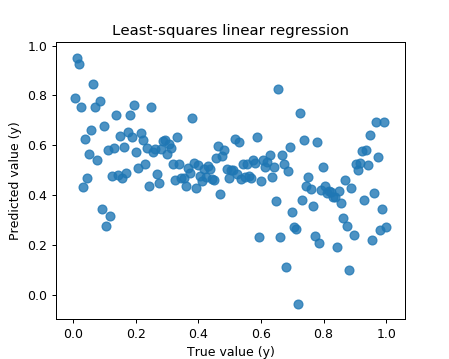

In [17]:
plt.figure(figsize=(5,4))
plt.scatter(y_test_nmpy, y_pred_model,marker= 'o', s=50, alpha=0.8)
#plt.plot(y_test_nmpy, y_pred_model, 'r-')
plt.title('Least-squares linear regression')
plt.xlabel('True value (y)')
plt.ylabel('Predicted value (y)')
plt.show()